# Fine Tuning XGBoost Parameters
This kernel will try to introduce you to regression with XGBoost and how to fine-tune its parameters for better results.

The following kernels were a huge help and I took some code snippets from them:
- [Regression to Predict House Prices by Elie Kawerk](https://www.kaggle.com/eliekawerk/regression-to-predict-house-prices)
- [Blending of 6 Models (Top 4%) by Sandeep Kumar](https://www.kaggle.com/sandeepkumar121995/blending-of-6-models-top-10)
- [Regularized Linear Models by Alexandru Papiu](https://www.kaggle.com/apapiu/regularized-linear-models)

In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

#ML
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split # Model evaluation
from lightgbm import LGBMRegressor, plot_importance # LGBM

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import datetime
import time
import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [98]:
# Load data and display info dataset
#df_train = pd.read_csv("../input/train.csv", index_col = 0) 
#df_test = pd.read_csv("../input/test.csv", index_col = 0) 

df_train = pd.read_csv("~/datasets/HP-ART//train.csv", index_col = 0) 
df_test = pd.read_csv("~/datasets/HP-ART//test.csv", index_col = 0) 

In [99]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

# Preprocessing

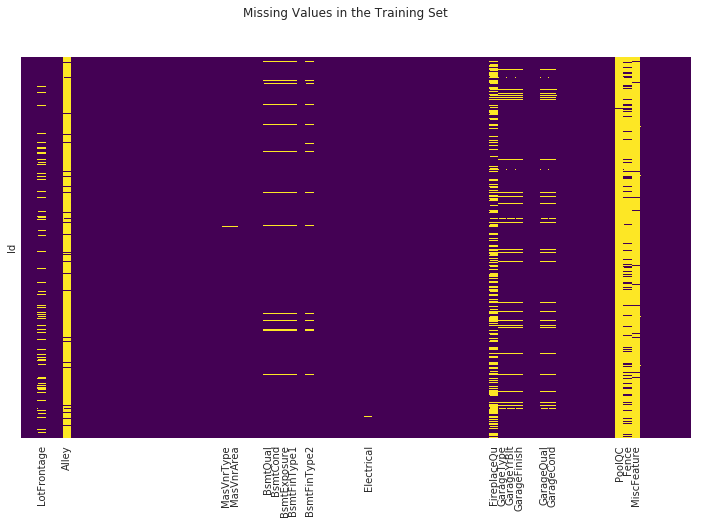

In [100]:
#display Missing values
label_nas = []
for col in df_train.columns.tolist():
    if np.sum(df_train[col].isnull() ) != 0:
        label_nas.append(col)
    else:
        label_nas.append("")

plt.figure(figsize=(12,7))
plt.suptitle('Missing Values in the Training Set')
sns.heatmap(df_train.isnull(), yticklabels=False, xticklabels=label_nas ,cbar = False, cmap='viridis')
plt.show()

In [101]:
#remove columns with too many missed values
null_values_per_col = np.sum(df_train.drop(["SalePrice"], axis=1).isnull(), axis=0)
max_na = int(df_train.shape[0]/3.0) #allowing up to 1/3 of the data to be missing
cols_to_remove = []

for col in df_train.drop(["SalePrice"],axis=1).columns.tolist():
    if null_values_per_col[col] > max_na: 
        cols_to_remove.append(col)
        df_train.drop(col, axis=1, inplace=True)
        
print("New shape of the training set is: (%d,%d)" %df_train.shape)        
print("The removed columns are: " + str(cols_to_remove))

#do the same for test dataset
df_test.drop(cols_to_remove, axis=1, inplace=True)

New shape of the training set is: (1460,75)
The removed columns are: ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [102]:
# MSSubClass is actually categorical even if expressed as numerical
df_train = df_train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}})


In [103]:
#remap some columns to have numerical data
rep_map_1 = {"NA": 0, "Po": 1,
             "Fa": 2, "TA": 3, 
             "Gd": 4, "Ex": 5,}

rep_map_2 = {"NA": 0, "No": 1,
             "Mn": 2, "Av": 3, 
             "Gd": 4,}

rep_map_3 = {"NA": 0, "Unf": 1,
             "LwQ": 2, "Rec": 3, 
             "BLQ": 4, "ALQ": 5,
             "GLQ": 6,}

rep_map_4 = {"NA": 0, "MnWw": 1,
             "GdWo": 2, "MnPrv": 3, 
             "GdPrv": 4,}

scale_list_1 = ["ExterCond", "BsmtCond", "HeatingQC", "KitchenQual", "GarageCond"]
scale_list_2 = ["BsmtFinType1"]
scale_list_3 = ["BsmtFinType2"]
scale_list_4 = ["Fence"]

In [104]:
for s in scale_list_1:
    df_train = df_train.replace({s:rep_map_1,})
    df_test = df_test.replace({s:rep_map_1,})

df_train = df_train.replace({scale_list_2[0]:rep_map_2,
                             scale_list_3[0]:rep_map_3,
                             scale_list_4[0]:rep_map_4,})

df_test = df_test.replace({scale_list_2[0]:rep_map_2,
                             scale_list_3[0]:rep_map_3,
                             scale_list_4[0]:rep_map_4,})

In [105]:
#Correlation matrix
corr_mat = df_train.corr().abs()
# Find most important features relative to target
corr_mat.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr_mat.SalePrice)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
KitchenQual      0.659600
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
HeatingQC        0.427649
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
KitchenAbvGr     0.135907
EnclosedPorch    0.128578
GarageCond       0.125013
ScreenPorch      0.111447
PoolArea         0.092404
OverallCond      0.077856
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinType2     0.040139
YrSold           0.028923
LowQualFinSF     0.025606
MiscVal          0.021190
ExterCond   

In [106]:
#Correlation matrix between features
corr_mat = df_train.drop(columns=["SalePrice"]).corr().abs()

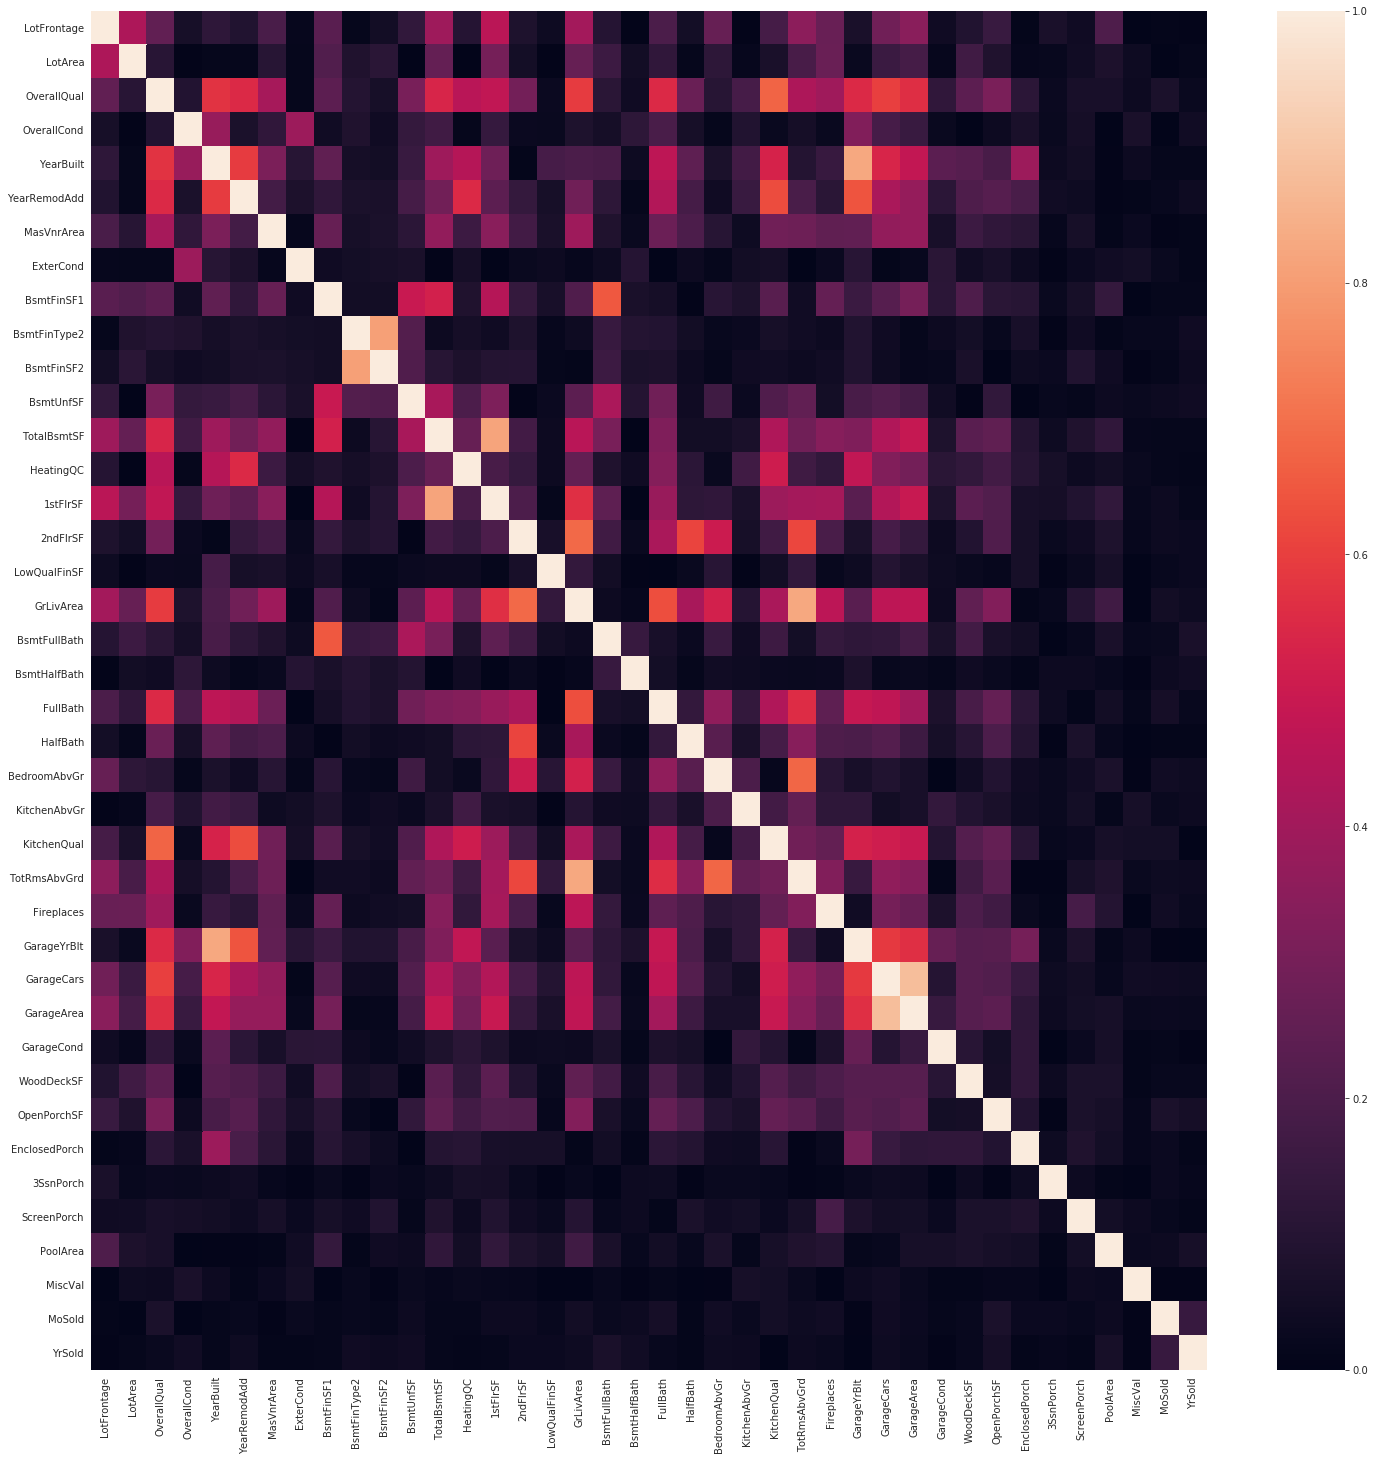

In [107]:
#Plot the heatmap with seaborn
plt.figure(figsize=(25,25)) 
sns.heatmap(corr_mat, 
        xticklabels=corr_mat.columns,
        yticklabels=corr_mat.columns)

In [108]:
#List the highly correlated columns
corr_tmp = corr_mat.unstack()
corr_tmp = corr_tmp.sort_values(kind="quicksort")

print(corr_tmp[-len(corr_mat)-20:-len(corr_mat)])

YearRemodAdd  GarageYrBlt     0.642277
GarageYrBlt   YearRemodAdd    0.642277
BsmtFinSF1    BsmtFullBath    0.649212
BsmtFullBath  BsmtFinSF1      0.649212
OverallQual   KitchenQual     0.673331
KitchenQual   OverallQual     0.673331
BedroomAbvGr  TotRmsAbvGrd    0.676620
TotRmsAbvGrd  BedroomAbvGr    0.676620
GrLivArea     2ndFlrSF        0.687501
2ndFlrSF      GrLivArea       0.687501
BsmtFinSF2    BsmtFinType2    0.805212
BsmtFinType2  BsmtFinSF2      0.805212
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
YearBuilt     GarageYrBlt     0.825667
GarageYrBlt   YearBuilt       0.825667
GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
dtype: float64


In [109]:
#Remove highly correlated columns if needed, I will skip that
rm_corr = False
if rm_corr:
    columns_corr = ["GarageYrBlt", "GarageCars", "GrLivArea"]
    df_train = df_train.drop(columns=columns_corr)
    df_test = df_test.drop(columns=columns_corr)

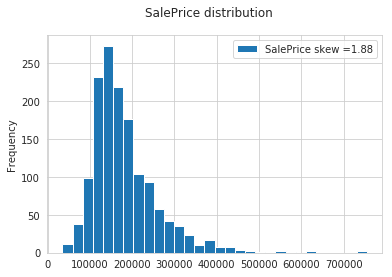

In [110]:
#Check the skewness of SalePrice
skewness = df_train['SalePrice'].skew()
df_train['SalePrice'].plot.hist(edgecolor='white', bins=30, 
                                label='SalePrice skew =' + str(round(skewness,2)))
plt.suptitle("SalePrice distribution")
plt.legend()
plt.show()

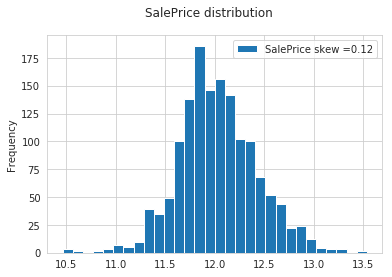

In [111]:
#Apply log1p to reduce skewness
skewness = np.log1p(df_train['SalePrice']).skew()
np.log(df_train['SalePrice']).plot.hist(edgecolor='white', bins=30, 
                                label='SalePrice skew =' + str(round(skewness,2)))
plt.suptitle("SalePrice distribution")
plt.legend()
plt.show()

In [112]:
# Log transform the SalePrice column
df_train['SalePrice'] = np.log1p(df_train['SalePrice'])

In [113]:
#Get a list of all numerical and categorical features
categorical_list = []
numerical_list = []

for col in df_train.drop(columns=["SalePrice"]).columns.tolist():
    if df_train[col].dtype == 'object':
        categorical_list.append(col)
    else:
        numerical_list.append(col)

In [114]:
# Log transform of the skewed numerical features to lessen impact of outliers
skewness = df_train[numerical_list].skew()
skewness = skewness[abs(skewness) > 0.7]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
df_train[skewed_features] = np.log1p(df_train[skewed_features])
df_test[skewed_features] = np.log1p(df_test[skewed_features])

23 skewed numerical features to log transform


In [115]:
#Convert categorical variables into dummy/indicator variables
df_train = pd.get_dummies(df_train, columns=categorical_list)
df_test = pd.get_dummies(df_test, columns=categorical_list)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 265 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(25), int64(16), uint8(224)
memory usage: 798.4 KB


In [116]:
#If you chose to leave out some columns, remove them now
for col in df_train.columns.tolist():
    if df_train[col].dtype == 'object':
        del df_train[col]
        del df_test[col]
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Columns: 265 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(25), int64(16), uint8(224)
memory usage: 798.4 KB


In [117]:
train_stats = df_train.describe()
train_stats

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterCond,BsmtFinSF1,BsmtFinType2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1422.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,4.207109,9.110966,6.099315,5.575342,1971.267808,1984.865753,2.131946,1.403450,4.229731,0.780863,...,0.003425,0.083562,0.002055,0.867808,0.069178,0.002740,0.008219,0.013699,0.820548,0.085616
std,0.346228,0.517369,1.382997,1.112799,30.202904,20.645407,2.631265,0.083330,2.992052,0.258802,...,0.058440,0.276824,0.045299,0.338815,0.253844,0.052289,0.090317,0.116277,0.383862,0.279893
min,3.091042,7.170888,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.693147,0.000000,0.693147,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.094345,8.929898,5.000000,5.000000,1954.000000,1967.000000,0.000000,1.386294,0.000000,0.693147,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,4.248495,9.156887,6.000000,5.000000,1973.000000,1994.000000,0.000000,1.386294,5.951943,0.693147,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.394449,9.358976,7.000000,6.000000,2000.000000,2004.000000,5.117994,1.386294,6.569832,0.693147,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,5.749393,12.279537,10.000000,9.000000,2010.000000,2010.000000,7.378384,1.791759,8.638525,1.945910,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
#prepare for splitting and normalization
df_train_tmp = df_train.drop(columns=["SalePrice"]) #Normalize across the whole training dataset
norm = False
def norm(x):
    #return (x - train_stats['mean']) / train_stats['std']
    return (x - df_train_tmp.mean()) / (df_train_tmp.max() - df_train_tmp.min())

In [119]:
#Normalise, split Z and Y, split data into 80% training and 20% validation set
y_full = df_train.pop('SalePrice')
if norm:
    X_full = norm(df_train)
    X_test = norm(df_test)
else:
    X_full = df_train
    X_test = df_test

X_train, X_val, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=123)

# Parameter Tuning

In [186]:
#Cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
#Function to quickly recreate the model when needed
model = LGBMRegressor(objective='regression',
                          num_iterations = 2000,
                          learning_rate = 0.01,
                          bagging_freq = 5,
                          bagging_fraction = 0.8, #subsample
                          feature_fraction = 0.4, #colsample_bytree
                          device_type='cpu',
                          random_state=123)

In [187]:
# 1: optimise n_estimators and max_depth
# the range to explore depends on the problem, and your observations while trying 
# for the meaning of each parameter, check the official documentation 
# https://lightgbm.readthedocs.io/en/latest/Parameters.html
# https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html

num_leaves = [7, 11, 17] #11
min_data_in_leaf = [1, 2, 3] #2
max_depth = [3, 5, 7] #5

max_bin = [31, 47, 63] #47

# create dictionary with the parameters
param_grid = dict(num_leaves=num_leaves, max_bin=max_bin, max_depth=max_depth,
                  min_data_in_leaf=min_data_in_leaf)

print("number of combinations: {}".format(len(max_depth)*len(num_leaves)*len(max_bin)*len(min_data_in_leaf)))

number of combinations: 81


In [188]:
#fine tune the model
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)
grid_result = grid_search.fit(X_full, y_full)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   41.5s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  4.5min finished


In [189]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.014451 using {'max_bin': 47, 'max_depth': 5, 'min_data_in_leaf': 2, 'num_leaves': 11}
-0.015045 (0.002207) with: {'max_bin': 31, 'max_depth': 3, 'min_data_in_leaf': 1, 'num_leaves': 7}
-0.014892 (0.002200) with: {'max_bin': 31, 'max_depth': 3, 'min_data_in_leaf': 1, 'num_leaves': 11}
-0.014892 (0.002200) with: {'max_bin': 31, 'max_depth': 3, 'min_data_in_leaf': 1, 'num_leaves': 17}
-0.014708 (0.002139) with: {'max_bin': 31, 'max_depth': 3, 'min_data_in_leaf': 2, 'num_leaves': 7}
-0.014713 (0.002106) with: {'max_bin': 31, 'max_depth': 3, 'min_data_in_leaf': 2, 'num_leaves': 11}
-0.014713 (0.002106) with: {'max_bin': 31, 'max_depth': 3, 'min_data_in_leaf': 2, 'num_leaves': 17}
-0.014953 (0.002231) with: {'max_bin': 31, 'max_depth': 3, 'min_data_in_leaf': 3, 'num_leaves': 7}
-0.014744 (0.002210) with: {'max_bin': 31, 'max_depth': 3, 'min_data_in_leaf': 3, 'num_leaves': 11}
-0.014744 (0.002210) with: {'max_bin': 31, 'max_depth': 3, 'min_data_in_leaf': 3, 'num_leaves': 17}
-0.01506

# Training

In [306]:
# final model with tuned parameters
model = LGBMRegressor(objective='regression',
                       num_leaves=17, #dflt 31
                       learning_rate=0.01, #dflt 0.1
                       num_iterations=2000, #n_estimators dflt 100
                       max_bin = 63, #dflt 63
                       max_depth = 5,
                       bagging_freq = 5,
                       bagging_fraction = 0.8, #subsample 0.8
                       feature_fraction = 0.4, #colsample_bytree 0.2319 
                       min_data_in_leaf = 2, #dflt = 20 
                       min_sum_hessian_in_leaf = 1e-3, #min_child_weight, dflt 1e-3
                       device_type='cpu', #gpu was slower than cpu for some reason!
                       random_state=123)

In [309]:
# final Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=123)
results = cross_val_score(model, X_full, y_full, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, verbose=3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.2s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


In [310]:
# CV results
results_rmsle = np.sqrt(-results)
print("-MSE: {} ({})".format(results.mean(),results.std()))
print("RMS(L)E: {} ({})".format(results_rmsle.mean(),results_rmsle.std()))

-MSE: -0.014472154843629756 (0.002294138602071815)
RMS(L)E: 0.11992189971435921 (0.009533772208781294)


In [307]:
#Final training
tick=time.time()

fitted_model = model.fit(X_train, y_train,
                         eval_set=[(X_val, y_val)],
                         eval_metric='rmse', # Equivalent to RMSLE since we have log1p(SalePrice)
                         early_stopping_rounds=100,
                         verbose=True)

print("Duration: {}s".format(time.time()-tick))

[1]	valid_0's l2: 0.146441	valid_0's rmse: 0.382676
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 0.144181	valid_0's rmse: 0.379711
[3]	valid_0's l2: 0.141972	valid_0's rmse: 0.376791
[4]	valid_0's l2: 0.140005	valid_0's rmse: 0.374172
[5]	valid_0's l2: 0.138103	valid_0's rmse: 0.371622
[6]	valid_0's l2: 0.13616	valid_0's rmse: 0.368999
[7]	valid_0's l2: 0.134079	valid_0's rmse: 0.366168
[8]	valid_0's l2: 0.132047	valid_0's rmse: 0.363382
[9]	valid_0's l2: 0.130106	valid_0's rmse: 0.360703
[10]	valid_0's l2: 0.12814	valid_0's rmse: 0.357966
[11]	valid_0's l2: 0.126338	valid_0's rmse: 0.355441
[12]	valid_0's l2: 0.124407	valid_0's rmse: 0.352713
[13]	valid_0's l2: 0.122572	valid_0's rmse: 0.350103
[14]	valid_0's l2: 0.120766	valid_0's rmse: 0.347514
[15]	valid_0's l2: 0.119244	valid_0's rmse: 0.345317
[16]	valid_0's l2: 0.117574	valid_0's rmse: 0.342891
[17]	valid_0's l2: 0.115781	valid_0's rmse: 0.340266
[18]	valid_0's l2: 0.114127	valid_0's rmse: 0.3

[258]	valid_0's l2: 0.0165742	valid_0's rmse: 0.128741
[259]	valid_0's l2: 0.0165084	valid_0's rmse: 0.128485
[260]	valid_0's l2: 0.0164633	valid_0's rmse: 0.128309
[261]	valid_0's l2: 0.0164254	valid_0's rmse: 0.128162
[262]	valid_0's l2: 0.0163842	valid_0's rmse: 0.128001
[263]	valid_0's l2: 0.0163492	valid_0's rmse: 0.127864
[264]	valid_0's l2: 0.0162948	valid_0's rmse: 0.127651
[265]	valid_0's l2: 0.0162415	valid_0's rmse: 0.127442
[266]	valid_0's l2: 0.0161893	valid_0's rmse: 0.127237
[267]	valid_0's l2: 0.0161498	valid_0's rmse: 0.127082
[268]	valid_0's l2: 0.0161107	valid_0's rmse: 0.126928
[269]	valid_0's l2: 0.0160746	valid_0's rmse: 0.126786
[270]	valid_0's l2: 0.0160269	valid_0's rmse: 0.126598
[271]	valid_0's l2: 0.0159702	valid_0's rmse: 0.126373
[272]	valid_0's l2: 0.0159316	valid_0's rmse: 0.12622
[273]	valid_0's l2: 0.0158925	valid_0's rmse: 0.126066
[274]	valid_0's l2: 0.0158434	valid_0's rmse: 0.12587
[275]	valid_0's l2: 0.0158059	valid_0's rmse: 0.125721
[276]	valid_

[437]	valid_0's l2: 0.0123257	valid_0's rmse: 0.111021
[438]	valid_0's l2: 0.012309	valid_0's rmse: 0.110946
[439]	valid_0's l2: 0.0123022	valid_0's rmse: 0.110915
[440]	valid_0's l2: 0.0122977	valid_0's rmse: 0.110895
[441]	valid_0's l2: 0.0122905	valid_0's rmse: 0.110863
[442]	valid_0's l2: 0.0122787	valid_0's rmse: 0.110809
[443]	valid_0's l2: 0.0122609	valid_0's rmse: 0.110729
[444]	valid_0's l2: 0.0122496	valid_0's rmse: 0.110678
[445]	valid_0's l2: 0.0122491	valid_0's rmse: 0.110675
[446]	valid_0's l2: 0.0122399	valid_0's rmse: 0.110634
[447]	valid_0's l2: 0.0122264	valid_0's rmse: 0.110573
[448]	valid_0's l2: 0.0122192	valid_0's rmse: 0.11054
[449]	valid_0's l2: 0.012212	valid_0's rmse: 0.110508
[450]	valid_0's l2: 0.0122071	valid_0's rmse: 0.110486
[451]	valid_0's l2: 0.0121942	valid_0's rmse: 0.110427
[452]	valid_0's l2: 0.0121807	valid_0's rmse: 0.110366
[453]	valid_0's l2: 0.0121703	valid_0's rmse: 0.110319
[454]	valid_0's l2: 0.0121551	valid_0's rmse: 0.11025
[455]	valid_0'

[674]	valid_0's l2: 0.0110358	valid_0's rmse: 0.105051
[675]	valid_0's l2: 0.0110344	valid_0's rmse: 0.105045
[676]	valid_0's l2: 0.0110336	valid_0's rmse: 0.105041
[677]	valid_0's l2: 0.0110327	valid_0's rmse: 0.105037
[678]	valid_0's l2: 0.0110321	valid_0's rmse: 0.105034
[679]	valid_0's l2: 0.0110328	valid_0's rmse: 0.105037
[680]	valid_0's l2: 0.0110355	valid_0's rmse: 0.10505
[681]	valid_0's l2: 0.0110358	valid_0's rmse: 0.105051
[682]	valid_0's l2: 0.0110324	valid_0's rmse: 0.105035
[683]	valid_0's l2: 0.0110346	valid_0's rmse: 0.105046
[684]	valid_0's l2: 0.0110335	valid_0's rmse: 0.10504
[685]	valid_0's l2: 0.0110351	valid_0's rmse: 0.105048
[686]	valid_0's l2: 0.0110353	valid_0's rmse: 0.105049
[687]	valid_0's l2: 0.0110316	valid_0's rmse: 0.105031
[688]	valid_0's l2: 0.0110298	valid_0's rmse: 0.105023
[689]	valid_0's l2: 0.011032	valid_0's rmse: 0.105033
[690]	valid_0's l2: 0.011032	valid_0's rmse: 0.105033
[691]	valid_0's l2: 0.0110333	valid_0's rmse: 0.10504
[692]	valid_0's

[949]	valid_0's l2: 0.0108084	valid_0's rmse: 0.103964
[950]	valid_0's l2: 0.0108073	valid_0's rmse: 0.103958
[951]	valid_0's l2: 0.0108081	valid_0's rmse: 0.103962
[952]	valid_0's l2: 0.0108108	valid_0's rmse: 0.103975
[953]	valid_0's l2: 0.0108092	valid_0's rmse: 0.103967
[954]	valid_0's l2: 0.0108174	valid_0's rmse: 0.104007
[955]	valid_0's l2: 0.0108173	valid_0's rmse: 0.104006
[956]	valid_0's l2: 0.0108167	valid_0's rmse: 0.104003
[957]	valid_0's l2: 0.0108148	valid_0's rmse: 0.103994
[958]	valid_0's l2: 0.0108142	valid_0's rmse: 0.103991
[959]	valid_0's l2: 0.0108182	valid_0's rmse: 0.104011
[960]	valid_0's l2: 0.0108189	valid_0's rmse: 0.104014
[961]	valid_0's l2: 0.0108185	valid_0's rmse: 0.104012
[962]	valid_0's l2: 0.0108221	valid_0's rmse: 0.104029
[963]	valid_0's l2: 0.0108207	valid_0's rmse: 0.104022
[964]	valid_0's l2: 0.0108194	valid_0's rmse: 0.104016
[965]	valid_0's l2: 0.0108195	valid_0's rmse: 0.104017
[966]	valid_0's l2: 0.0108179	valid_0's rmse: 0.104009
[967]	vali

Duration: 1.179570198059082s


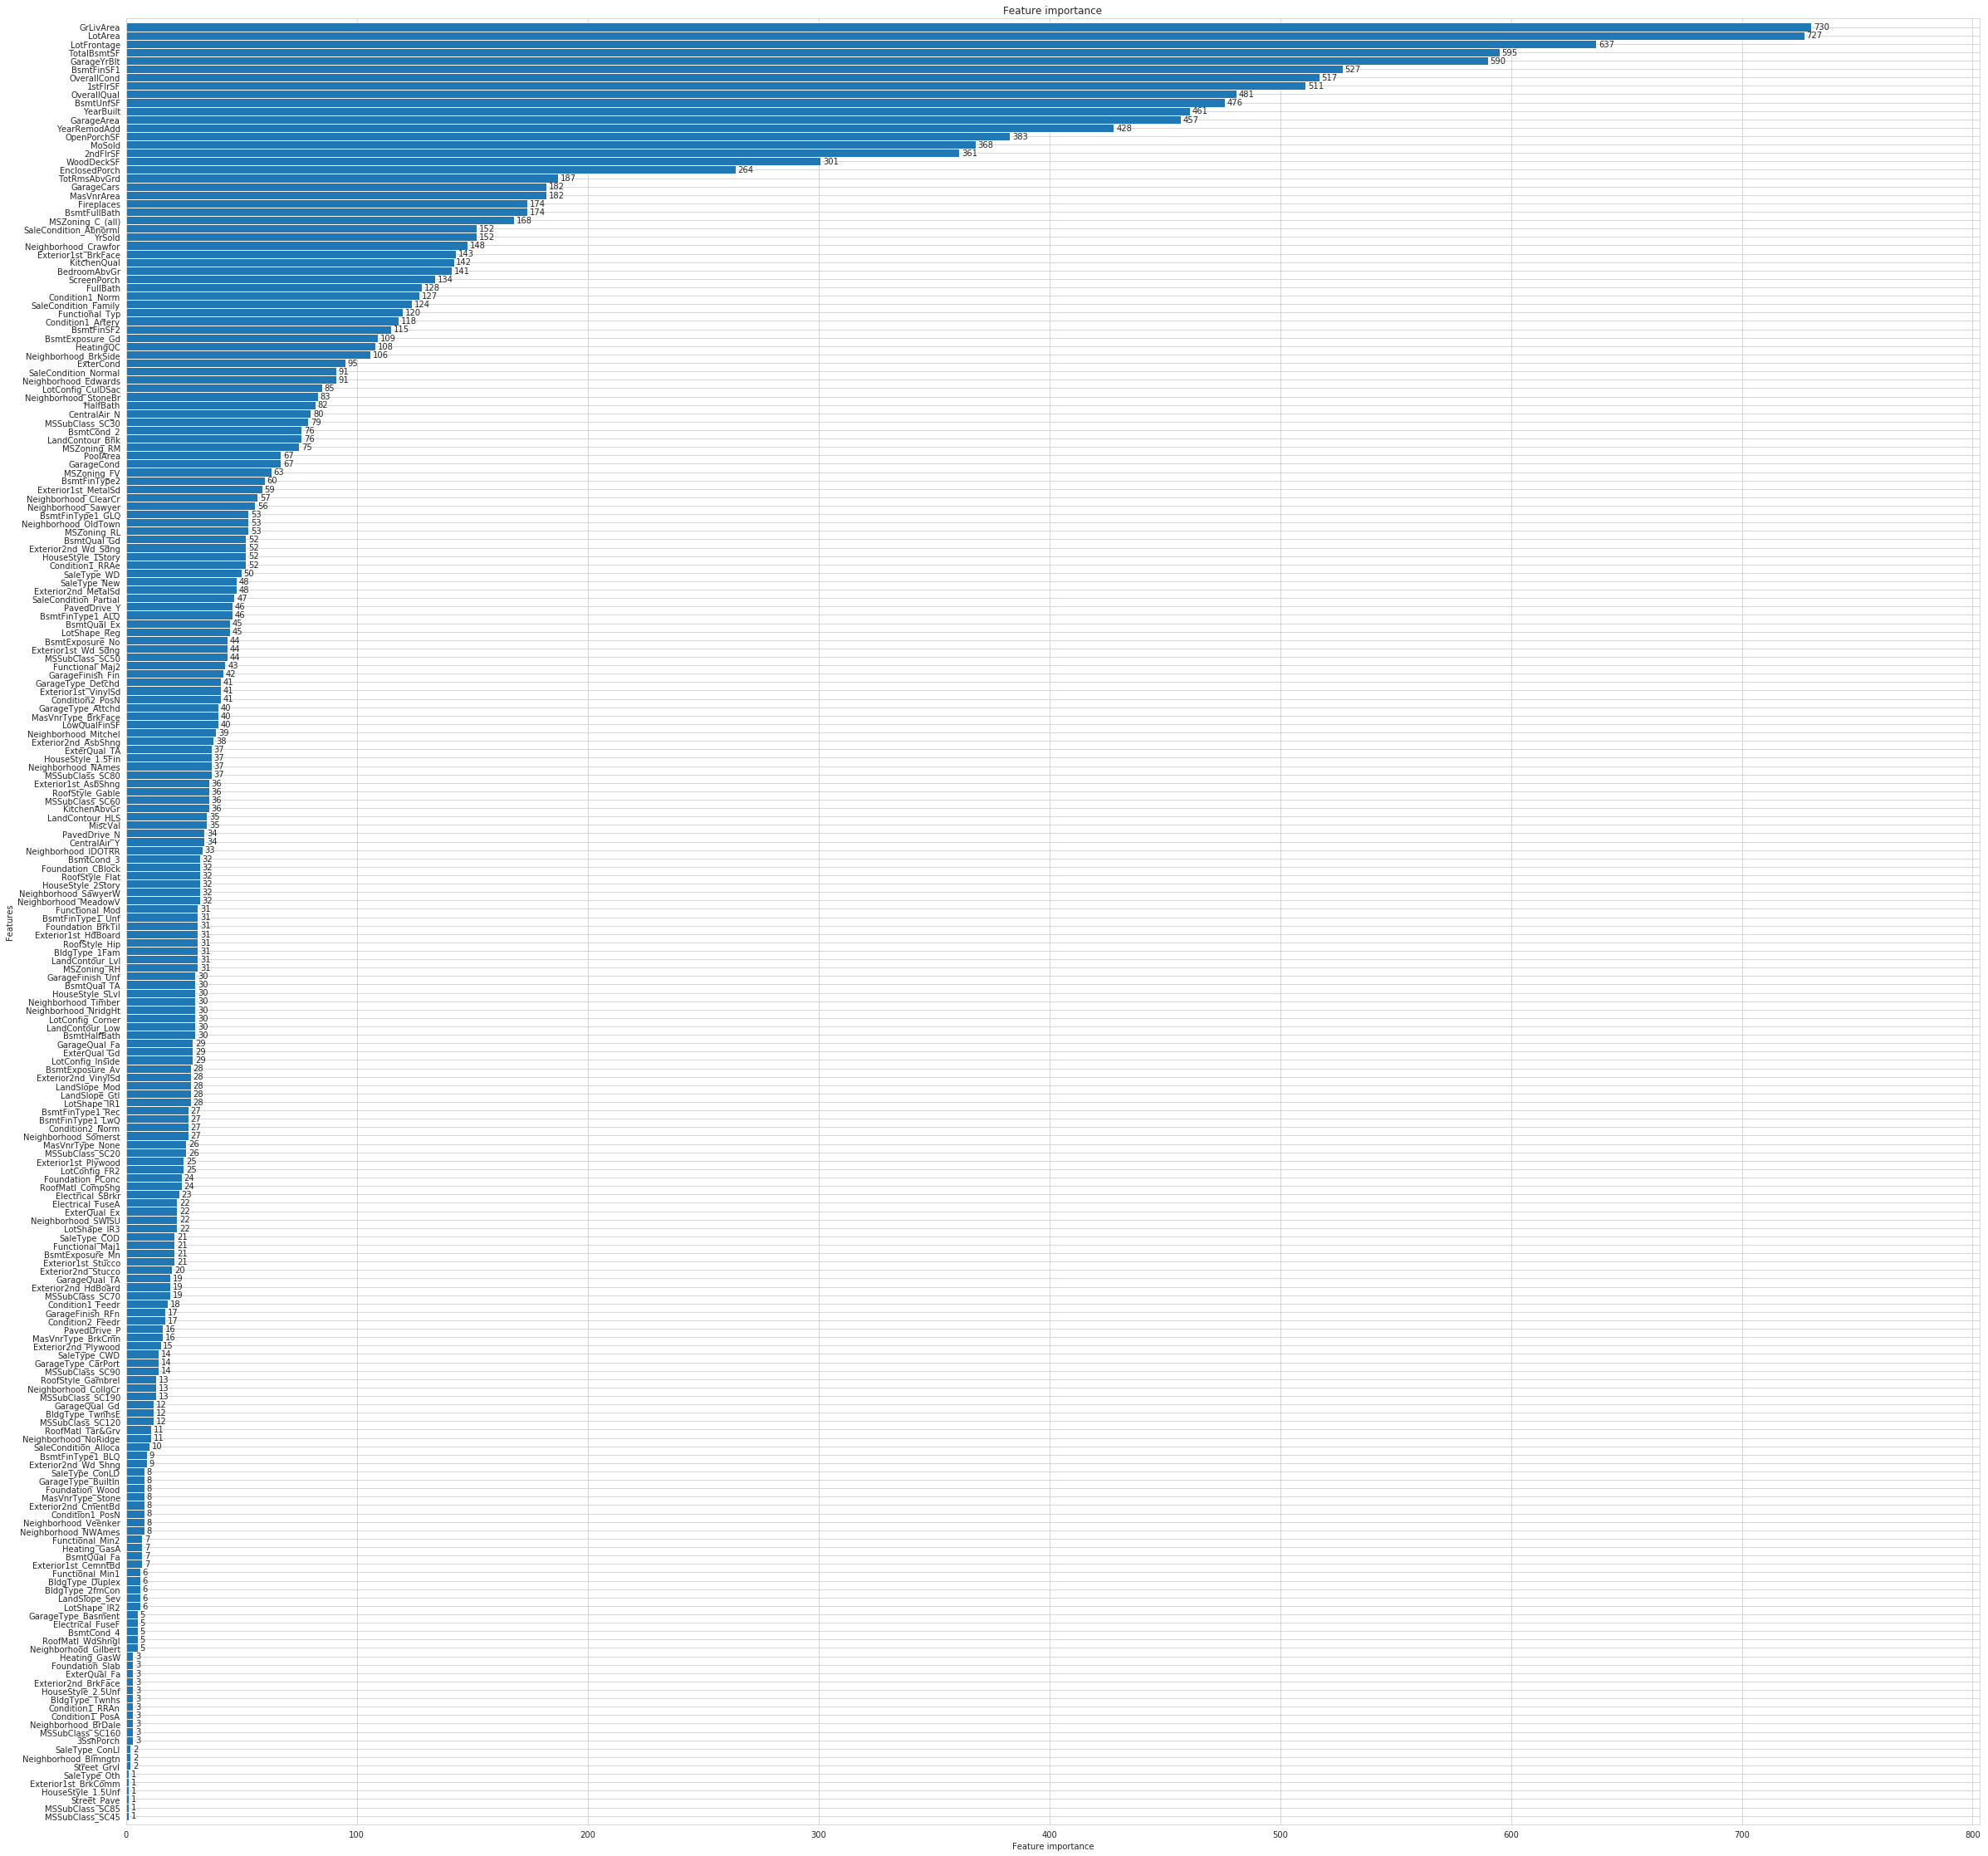

In [311]:
# Plot feature importance
figsize=(40,40)
fig, ax = plt.subplots(1,1,figsize=figsize)
plot_importance(model, ax=ax,height = 1)

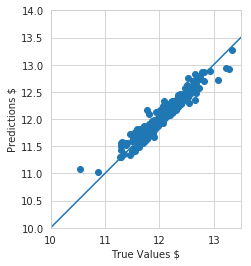

In [312]:
# predict sales in validation dataset
val_predictions = model.predict(X_val).flatten()

# scatter plot of True vs Predicted values
plt.scatter(y_val, val_predictions)
plt.xlabel('True Values $')
plt.ylabel('Predictions $')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,plt.xlim()[1]])
plt.ylim([10,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

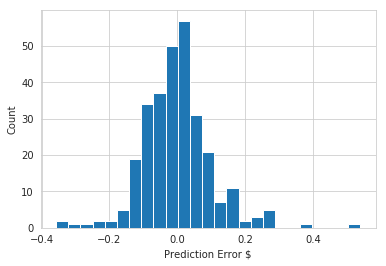

In [313]:
# Histogram of error values
error = val_predictions - y_val
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error $")
_ = plt.ylabel("Count")

# Submission

In [182]:
# predict sales for test dataset
predictions = model.predict(X_test[X_train.columns]) # keep columns in same order
# reverse log1p, and round results
predictions = np.round(np.exp(predictions)-1)
print(predictions)

[123569. 161703. 181738. ... 160313. 115601. 227422.]


In [183]:
# prepare dataframe to submit
submission = pd.DataFrame({'Id': df_test.index, 'SalePrice': predictions})
submission.head()

,Id,SalePrice
0,1461,123569.0
1,1462,161703.0
2,1463,181738.0
3,1464,183292.0
4,1465,182929.0


In [184]:
# submit
t_stamp = str(datetime.datetime.now())
t1 = t_stamp.split(" ")[0]
t2 = t_stamp.split(" ")[1].split(".")[0]
submission.to_csv('lgbm2_{}_{}_{}.csv'.format(t1, t2, round(results_rmsle.mean(),5)), index=False)

In [262]:
v1 = 0.05 * (0.99 ** 1)
v2 = 0.05 * (0.99 ** 10)
v3 = 0.05 * (0.99 ** 100)
v4 = 0.05 * (0.99 ** 1000)
v5 = 0.05 * (0.99 ** 2000)

In [263]:
print(v1, v2, v3, v4, v5)

0.0495 0.04521910375044022 0.01830161706366146 2.158562370532893e-06 9.318783014961166e-11


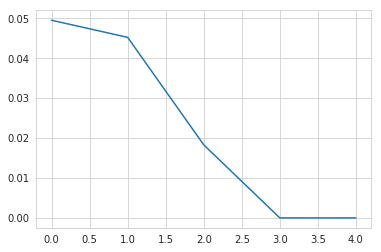

In [264]:
plt.plot([v1,v2,v3,v4,v5])

In [254]:
import lightgbm as lgb

In [255]:
#dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

In [303]:
# parameters of the model
params = {'objective':'regression',
          'metric': 'rmse',
                       'num_leaves':17, #dflt 31
                       'learning_rate':0.01, #dflt 0.1
                       'max_bin': 63, #dflt 63
                       'max_depth': 5,
                       'bagging_freq': 5,
                       'bagging_fraction': 0.8, #subsample 0.8
                       'feature_fraction': 0.4, #colsample_bytree 0.2319 
                       'min_data_in_leaf': 2, #dflt = 20 
                       'min_sum_hessian_in_leaf':1e-3, #min_child_weight, dflt 1e-3
                       'device_type':'cpu', #gpu was slower than cpu for some reason!
                       'random_state':123  
}

In [305]:
#Final training
tick=time.time()

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=2000,
                valid_sets=lgb_eval,
                early_stopping_rounds=100,
                verbose_eval=10)

print("Duration: {}s".format(time.time()-tick))

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's rmse: 0.358299
[20]	valid_0's rmse: 0.333377
[30]	valid_0's rmse: 0.311436
[40]	valid_0's rmse: 0.290214
[50]	valid_0's rmse: 0.272232
[60]	valid_0's rmse: 0.25683
[70]	valid_0's rmse: 0.242266
[80]	valid_0's rmse: 0.229102
[90]	valid_0's rmse: 0.217142
[100]	valid_0's rmse: 0.20618
[110]	valid_0's rmse: 0.196786
[120]	valid_0's rmse: 0.188053
[130]	valid_0's rmse: 0.180943
[140]	valid_0's rmse: 0.173363
[150]	valid_0's rmse: 0.167379
[160]	valid_0's rmse: 0.162057
[170]	valid_0's rmse: 0.157078
[180]	valid_0's rmse: 0.152519
[190]	valid_0's rmse: 0.148446
[200]	valid_0's rmse: 0.144861
[210]	valid_0's rmse: 0.14167
[220]	valid_0's rmse: 0.138719
[230]	valid_0's rmse: 0.136246
[240]	valid_0's rmse: 0.133543
[250]	valid_0's rmse: 0.131238
[260]	valid_0's rmse: 0.129107
[270]	valid_0's rmse: 0.127163
[280]	valid_0's rmse: 0.125663
[290]	valid_0's rmse: 0.12406
[300]	valid_0's rmse: 0.122699
[310]	valid_0's rmse